In [1]:
!pip install -e ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import pickle

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio
import xgeo

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

%load_ext autoreload
%autoreload 2


# snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc for snow only

Obtaining file:///home/nannau/temp/climpyrical/climpyrical_master/climpyrical
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
  Running setup.py develop for climpyrical
You should consider upgrading via the 'pip install --upgrade pip' command.


In [47]:
PATH = '../../climpyrical/tests/data/snw_test_ensemble.nc'
dv = 'Rain-RL50'
dsold = read_data(PATH, dv)

NNN = 3
ds = regrid_ensemble(dsold, dv, NNN)


WAS HERE


In [48]:
shape = ds[dv].values[0, ...].shape

In [49]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

canada = rotate_shapefile(can_geom)
# mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values, canada)
ytol = np.mean(np.diff(ds.rlat.values))
print(ds.rlat.values.min(), ytol, ds.rlat.values.min()+ytol)
np.isclose(ds.rlat.values.min(), -28.59999656677246, atol=ytol)

-28.746663224173453 0.14666665740099372 -28.59999656677246


True

WAS HERE


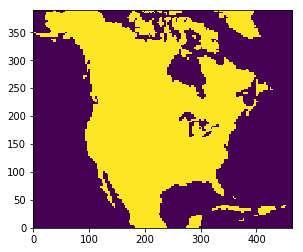

In [65]:
mask = read_data('/home/nannau/temp/climpyrical/climpyrical_master/climpyrical/climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', design_value_name='sftlf', keys={'rlat', 
'rlon'})
dvmask = 'sftlf'
# mask
mask = regrid_ensemble(mask, 'sftlf', NNN, keys={'rlat', 'rlon'})
mask = mask[dvmask].values >= 1.0
plt.imshow(mask, origin='lower')

In [66]:
from shapely.geometry import Polygon
canada.geometry

3    MULTIPOLYGON (((-16.66332 4.27477, -16.74606 4...
Name: geometry, dtype: geometry

In [67]:
# from rasterio import mask
from rasterio.features import geometry_mask
import rasterio

dataset = rasterio.open('../../climpyrical/tests/data/snw_test_ensemble_regridded.nc')
transform = dataset.transform
# m = mask.mask(dataset, canada.geometry)[0]
# dataset.close()

# mask = np.flipud(~np.isnan(m[0, ...]))
# plt.imshow(m[0, ...])
# plt.imshow(mask, origin='lower')
# mask

# from rasterio.features import geometry_mask
# mask = np.flipud(geometry_mask(canada, shape, transform=transform, invert=True))
# plt.imshow(mask)
# shape, transform
transform
print(transform)
# affine.Affine(np.mean(np.diff(dsold.rlon), 0.0, -dsol.rlon.min(), 0.0, )

west = ds.rlon.values.min()
east = ds.rlon.values.max()
south = ds.rlat.values.min()
north = ds.rlat.values.max()
width = np.mean(np.diff(ds.rlon.values))
height = np.mean(np.diff(ds.rlat.values))


transform_manual = rasterio.transform.from_bounds(west, south, east, north, ds.rlon.size, ds.rlat.size)
# print(transform_manual)
# mask = np.flipud(geometry_mask(canada, shape, transform=transform_manual, invert=True))
# plt.imshow(mask)
# mask

| 0.15, 0.00,-34.10|
| 0.00,-0.15, 28.38|
| 0.00, 0.00, 1.00|


In [68]:
ens_mean = np.mean(ds[dv].values, axis=0)
ens_mean.shape

(390, 465)

In [69]:
# Create a mask of extra NaN values that is flattened
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape

In [70]:
df = pd.read_csv('../../climpyrical/tests/data/stations.csv', index_col=None)
station_dv = 'RL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)
df = df[df['RL50 (kPa)'] != 0.0]

# Add nearest rlon and rlat locations in grid to stations
rlon_nearest_index, rlat_nearest_index = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

# df = df.assign(
#         rlon=rlon[rlat_nearest_index, rlon_nearest_index], 
#         rlat=rlat[rlat_nearest_index, rlon_nearest_index]
# )

df = df.assign(
    label='stations',
    rlon_nearest_index = rlon_nearest_index, 
    rlat_nearest_index = rlat_nearest_index,
    nearest_grid = list(zip(rlon_nearest_index, rlat_nearest_index))
)

# Group together stations falling in same grid cell and take mean
ndf = df.groupby(['nearest_grid'], as_index=False).agg({
                                station_dv: 'mean',
                                'lat':'min',
                                'lon':'min',
                                'rlat': 'min',
                                'rlon': 'min',
                                'rlon_nearest_index':'mean',
                                'rlat_nearest_index':'mean',
                                'label': 'min',
                            })

# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values

In [71]:
from sklearn.metrics import pairwise_distances_argmin_min

distance_to_nearest_gridcell = pairwise_distances_argmin_min( 
    np.deg2rad(np.stack([ndf.rlon, ndf.rlat]).T), 
    np.deg2rad(
        np.stack([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
    ),
    metric='haversine'
    
)[1]*6371000/1000
ndf['distances']=distance_to_nearest_gridcell

In [72]:
ens_mean.shape

(390, 465)

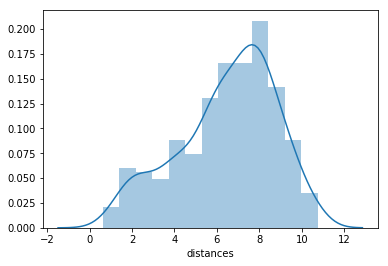

In [73]:
values = np.stack([ds.rlon.values[ndf.rlon_nearest_index], ds.rlat.values[ndf.rlat_nearest_index]])

ens_mean = ds[dv].values.mean(axis=0)


import warnings
warnings.simplefilter(action = "ignore", category = UserWarning)

x, y = flatten_coords(ds.rlon.values, ds.rlat.values, ds)
xreg, yreg = transform_coords(x, y, 
                 target_crs={"init": "epsg:4326"},
                 source_crs={
                    "proj": "ob_tran",
                    "o_proj": "longlat",
                    "lon_0": -97,
                    "o_lat_p": 42.5,
                    "a": 6378137,
                    "to_meter": 0.0174532925199,
                    "no_defs": True,
                }
)

# xi, yi = find_element_wise_nearest_pos(elevationds.lon.values, elevationds.lat.values, xreg, yreg)

# elevation_rp = elevationds.elev.values[yi, xi].reshape(ens_mean.shape)
# elevation_rp[~final_mask] = 0.0
# elevation_rp[np.isnan(elevation_rp)] = 0.
# elevation_rp[~final_mask] = np.nan

ndf = ndf.assign(
    mean_values = find_nearest_index_value(
        ds.rlon.values, 
        ds.rlat.values,
        rlon_i_agg, 
        rlat_i_agg, 
        ens_mean, 
        final_mask, 
        ds
    )
)



# plt.scatter(xxx[:,2], xxx[2,:])
sns.distplot(ndf['distances'])
# bases = np.array([find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, ds[dv][i,:,:].values, final_mask, ds) for i in range(35)])
# bases.shape

In [74]:
values = np.stack([ndf.rlon, ndf.rlat])
ndf['ratio'] = ndf[station_dv]/ndf.mean_values
X, Y = values.T, ndf['ratio'].values

In [61]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
loo = KFold(shuffle=True, n_splits=25)
# loo = LeaveOneOut()
score = []


model_arr = np.array([find_nearest_index_value(
    ds.rlon.values, 
    ds.rlat.values, 
    rlon_i_agg, 
    rlat_i_agg, 
    ds[dv].values[i, ...], final_mask, ds) for i in range(35)])

ratio = ndf[station_dv].values/model_arr

finals=[]
stds = []
stds_non_stations = []
stds_at_stations = []
stds_at_stations_with_error = []
stds_at_stations_no_error =[]
model = KNeighborsRegressor(n_neighbors=12, weights='distance')
scorey = []
for i in range(35):
    Y = ratio[i, :]
    X = np.stack([ndf.rlon, ndf.rlat]).T
    print(i)
#     Xtest = np.stack([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
#     model = KNeighborsRegressor(n_neighbors=k, weights='distance')
#     model.fit(X, Y)
#     print(model.score(Xtest, Y))
#     final = ens_mean.copy()
#     Xfull = np.stack([rlon[final_mask], rlat[final_mask]])
    
#     predfull = model.predict(Xfull.T)
#     pred_with_error = mean_squared_error(model.predict(Xtest)*model_arr[i, :], Y*model_arr[i, :])
    
#     stds_at_stations_with_error.append(pred_with_error)
#     stds_at_stations_no_error.append(mean_squared_error(model.predict(X)*model_arr[i, :], Y*model_arr[i, :]))
    
#     final[final_mask] = predfull
#     finalpred = ((np.ones(ens_mean.shape)-pwhole) + pwhole*final)*ds[dv].values[i, ...]
    
#     pred = find_nearest_index_value(
#                 ds.rlon.values, 
#                 ds.rlat.values, 
#                 rlon_i_agg, 
#                 rlat_i_agg, 
#                 finalpred, 
#                 final_mask, 
#                 ds)
#     pred_at_stations = finalpred[rlat_i_agg, rlon_i_agg]
    
#     stds.append(np.sqrt(mean_squared_error(pred, ratio[i, :]*model_arr[i, :])))
#     stds_at_stations.append(np.sqrt(mean_squared_error(pred_at_stations, ratio[i, :]*model_arr[i, :])))
#     stds_non_stations.append(np.sqrt(mean_squared_error(finalpred[final_mask], ds[dv].values[i, final_mask])))
    
#     finals.append(finalpred)
    score=[]
    for ks in range(2, 250):
        scores = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            model = KNeighborsRegressor(n_neighbors=ks, weights='distance')
            model.fit(X_train, y_train)

            ypred = model.predict(X_test)*model_arr[i, test_index]
            ytest = ndf[station_dv].values[test_index]

            Y_pred = np.sqrt(mean_squared_error(ypred, ytest))
            scores.append(Y_pred)

        score.append(np.mean(scores))
    scorey.append(score)

0
1
2


KeyboardInterrupt: 

In [75]:
scoreyarr = np.array(scorey)
scoreyarr.shape
scoreyarrmean = np.mean(scoreyarr, axis=0)
scoreyarrmean.shape

np.array(range(2, 250))[np.argmin(scoreyarr, axis=1)], np.argmin(scoreyarr, axis=1)

(array([211, 229]), array([209, 227]))

Text(0.5, 1.0, 'Minimum occurs when k=229')

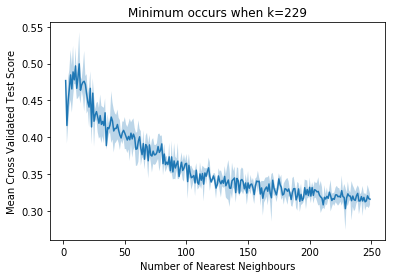

In [76]:
# plt.plot(n_neighbors, scores)
# for k in range(scoreyarr.shape[0]):
plt.plot(range(2, 250), np.mean(scoreyarr, axis=0))
plt.xlabel("Number of Nearest Neighbours")
plt.ylabel("Mean Cross Validated Test Score")
# plt.scatter(k, np.amin(scores), marker='x', s=75, color='black', label='Minimum')
plt.fill_between(range(2, 250),  np.min(scoreyarr, axis=0),  np.max(scoreyarr, axis=0), alpha=0.3)
plt.title(f"Minimum occurs when k={range(2, 250)[np.argmin(np.mean(scoreyarr, axis=0))]}")
# plt.savefig('/home/nannau/.notable/attachments/nearest_neighbour_cv.png')

In [77]:
k = range(2,200)[np.argmin(np.min(scoreyarr, axis=0))]

IndexError: range object index out of range

In [78]:
k=9

In [102]:
# values = np.stack([ndf.rlon, ndf.rlat])

X, Y = values.T, ndf['ratio'].values

model = KNeighborsRegressor(n_neighbors=k, weights='distance')
model.fit(X, Y)

def pwhole_(alpha):
    rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
    d_gridx = np.dstack((rlon, rlat))
    a = np.array([rlon[final_mask], rlat[final_mask]]).T
    a1 = np.array([df['rlon'].values, df['rlat'].values]).T
#     a1 = np.array([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X, Y)
    d = model.kneighbors_graph(a, mode='distance').toarray()
    fracs = np.linspace(0.2, -5)
    residual = []
    residual_plain = []
    residual_inv=[]
    psumar=[]

    denom = np.exp(-alpha*np.sum(np.sort(d, axis=1)[:, :1], axis=1))
    num = np.exp(-alpha*np.sort(distance.cdist(a, a1), axis=1)[:, 0])

    p = num/denom
    pwhole = ens_mean.copy()
    pwhole[final_mask] = p
    pwhole[~final_mask] = np.nan
    return pwhole.reshape(ens_mean.shape)

# pwhole_(-1.)

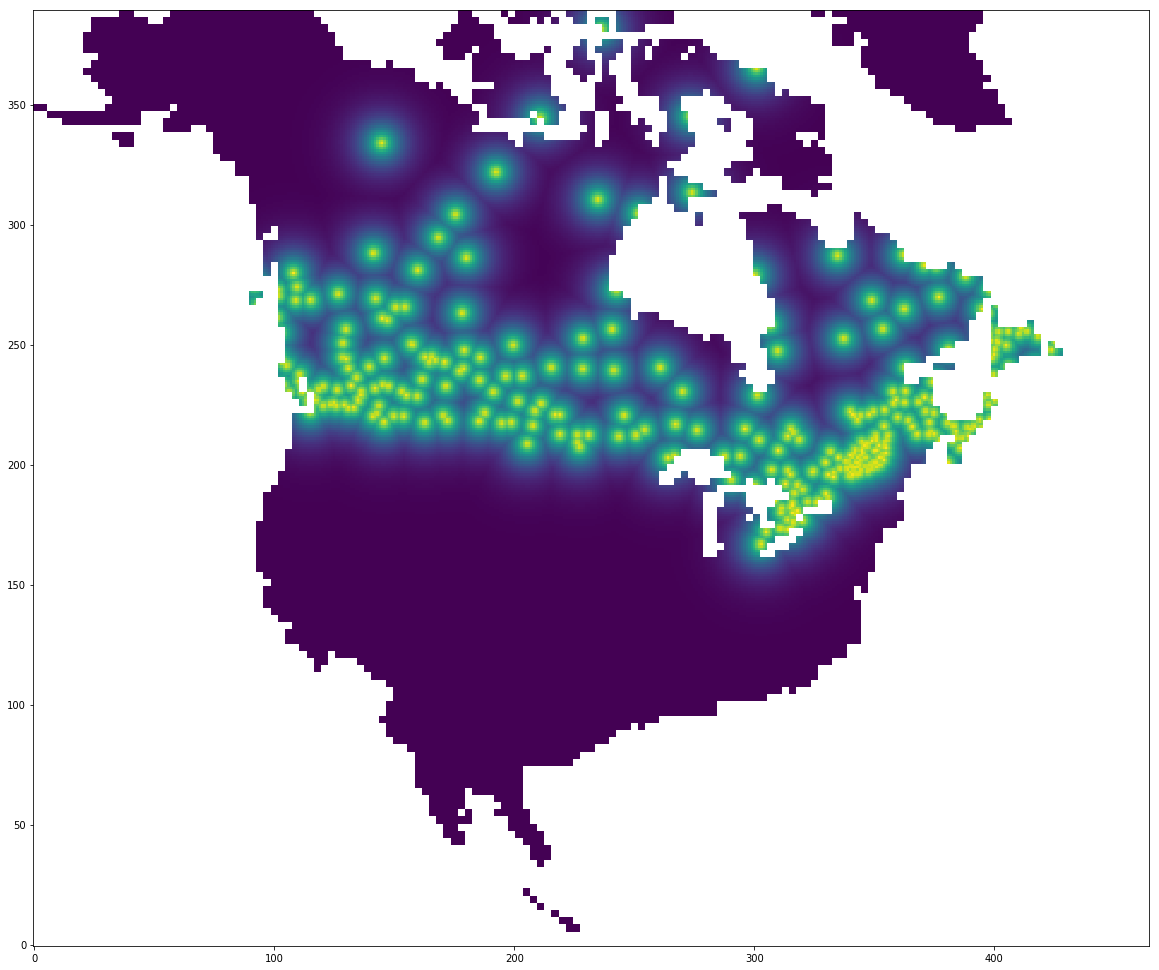

In [103]:
plt.figure(figsize=(20, 20))
plt.imshow(pwhole_(1.), origin='lower')

In [81]:
contains = []
x, y = rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]#ndf.rlon.values[i], ndf.rlat.values[i]

for i in range(x.size):
    contains.append(canada.contains(Point(x[i], y[i])).values[0])

np.sum(contains), np.sum(pwhole_(1.0) == 1.), Y.shape

(323, 0, (364,))

In [82]:
stations, mean = [], []
fracs = np.linspace(-1, 5, 30)

for frac in fracs:
    pwhole = pwhole_(frac)
    
    values = np.stack([ndf.rlon, ndf.rlat])
    ndf['ratio'] = ndf[station_dv]/ndf.mean_values
    
    final = ens_mean.copy()
    Xfull = np.stack([rlon[final_mask], rlat[final_mask]])
    predfull = model.predict(Xfull.T)
    final[final_mask] = predfull
    final = ((np.ones(ens_mean.shape)-pwhole) + pwhole*final)*ens_mean

    final[~final_mask] = np.nan


    pred = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, final.copy(), final_mask, ds)
    station_vals = ndf['ratio'].values*ndf.mean_values
    stations.append(np.sqrt(mean_squared_error(station_vals, pred))) 


In [83]:
stations=np.array(stations)
stations
f = float(fracs[np.argmin(stations)])
f, np.min(stations)

(5.0, 0.5057543648745652)

Text(0.5, 1.0, 'Softmax Density')

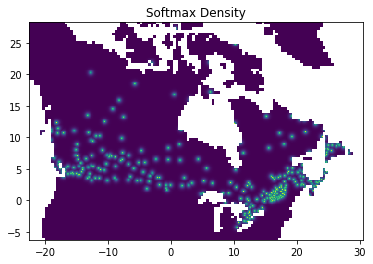

In [84]:
plt.imshow(pwhole_(f), origin='lower', extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()])
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.title("Softmax Density")
# plt.savefig('/home/nannau/.notable/attachments/softmax_density')

In [85]:
pwholes=[]
for alpha in np.array([10., f, 0.001]):
    pwholes.append(pwhole_(alpha))

In [86]:
# from matplotlib import rc
# # rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# # rc('text', usetex=True)
# del rc

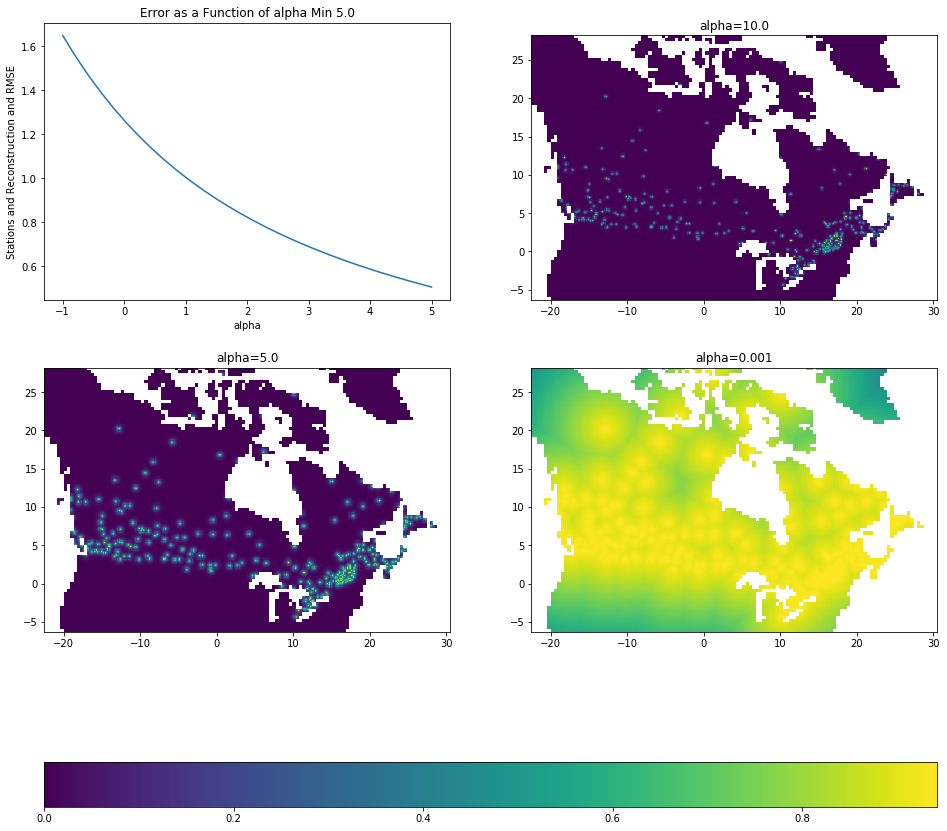

<Figure size 432x288 with 0 Axes>

In [87]:
fig, ax = plt.subplots(2,2, figsize=(16, 16))

ax[0, 0].set_title(f'Error as a Function of alpha Min {f}')
ax[0, 0].plot(fracs, stations)
ax[0, 0].set_xlabel('alpha')
ax[0, 0].set_ylabel('Stations and Reconstruction and RMSE')

ax[0, 1].set_title(f'alpha={10.}')
eg = ax[0, 1].imshow(pwholes[0], origin='lower', extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()])

ax[1, 0].set_title(f'alpha={f}')
ax[1, 0].imshow(pwholes[1], origin='lower', extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()])

ax[1, 1].set_title(f'alpha={0.001}')
ax[1, 1].imshow(pwholes[2], origin='lower', extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()])
fig.colorbar(eg, ax=ax[:, :], location='bottom')
ax[0, 1].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[0, 1].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[1, 0].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[1, 0].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[1, 1].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[1, 1].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.show()
plt.savefig('/home/nannau/.notable/attachments/alpha.png')

In [88]:
pwhole = pwhole_(f)
#
model

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='distance')

In [89]:
model_arr = np.array([find_nearest_index_value(
    ds.rlon.values, 
    ds.rlat.values, 
    rlon_i_agg, 
    rlat_i_agg, 
    ds[dv].values[i, ...], final_mask, ds) for i in range(35)])

ratio = ndf[station_dv].values/model_arr

finals=[]

stds = []
stations_pred_noerr = []
stds_non_stations = []
stds_at_stations = []
stds_at_stations_with_error = []
stds_at_stations_no_error =[]
final_noerr = []
final_noweighting = []
model = KNeighborsRegressor(n_neighbors=k, weights='distance')

for i in range(35):
    Y = ratio[i, :]
    X = np.stack([ndf.rlon, ndf.rlat]).T
    Xtest = np.stack([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X, Y)
    print(model.score(Xtest, Y))
    final = ens_mean.copy()
    Xfull = np.stack([rlon[final_mask], rlat[final_mask]])
    
    predfull = model.predict(Xfull.T)
    pred_with_error = mean_squared_error(model.predict(Xtest)*model_arr[i, :], Y*model_arr[i, :])
    
    stds_at_stations_with_error.append(pred_with_error)
    stds_at_stations_no_error.append(mean_squared_error(model.predict(X)*model_arr[i, :], Y*model_arr[i, :]))
    
    finalpred_nw = ens_mean.copy()
    
    final[final_mask] = predfull
    
    finalpred = ((np.ones(ens_mean.shape)-pwhole) + pwhole*final)*ds[dv].values[i, ...]    
    final_nw = final*ds[dv].values[i, ...]

    final_noerr.append(model.predict(X)*model_arr[i, :])
    final_noweighting.append(final_nw)
    stations_pred_noerr.append(Y*model_arr[i, :])

    pred = find_nearest_index_value(
                ds.rlon.values, 
                ds.rlat.values, 
                rlon_i_agg, 
                rlat_i_agg, 
                finalpred, 
                final_mask, 
                ds)
    pred_at_stations = finalpred[rlat_i_agg, rlon_i_agg]
    
    stds.append(np.sqrt(mean_squared_error(pred, ratio[i, :]*model_arr[i, :])))
    stds_at_stations.append(np.sqrt(mean_squared_error(pred_at_stations, ratio[i, :]*model_arr[i, :])))
    stds_non_stations.append(np.sqrt(mean_squared_error(finalpred[final_mask], ds[dv].values[i, final_mask])))
    
    finals.append(finalpred)



0.9316628713568968
0.9308016259194798
0.9315091404373079
0.9296568158633751
0.93098807053284
0.9286024272810812
0.9295151673980182
0.9344163499752534
0.9318169437098849
0.9252801175139282
0.9281174365307869
0.9291451511399376
0.9270793733365305
0.9323266194490233
0.9291380009242926
0.929359222917301
0.9330041275557576
0.9321517636821179
0.9326061074275726
0.9270115665656299
0.930419311572421
0.9296380287981719
0.9186128264425343
0.9312372663583146
0.9324899602413583
0.9239909575987094
0.9323518466634381
0.9315103727641703
0.9309712478687449
0.9263826858177476
0.92756325252519
0.9301284608420777
0.9292048933618986
0.930054129211481
0.9342584406660842


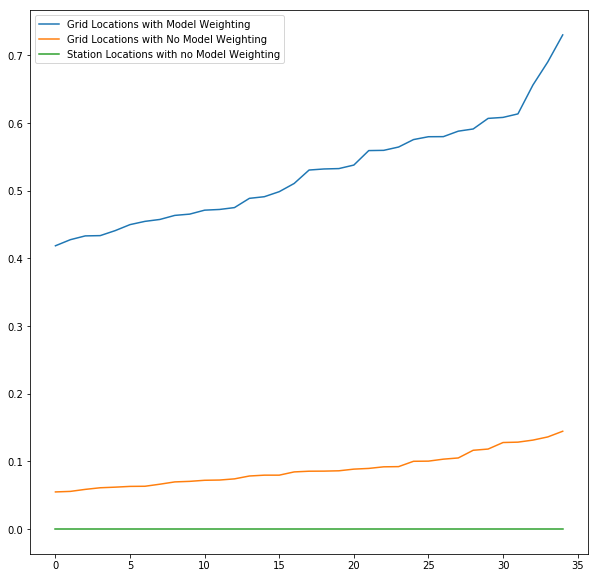

In [90]:
plt.figure(figsize=(10, 10))
plt.plot(range(35), np.array(stds)[np.argsort(stds)], label='Grid Locations with Model Weighting')
# plt.plot(range(35), np.array(stds_at_stations)[np.argsort(stds_at_stations)], label='Station Locations with Model Weighting')
plt.plot(range(35), np.array(stds_at_stations_with_error)[np.argsort(stds_at_stations_with_error)], label='Grid Locations with No Model Weighting')
plt.plot(range(35), np.array(stds_at_stations_no_error)[np.argsort(stds_at_stations_no_error)], label='Station Locations with no Model Weighting')
plt.legend()

In [91]:
N=2
score_st = []
score_ens = []
rs = range(N, 35)
for n in rs:
    final = np.mean(np.array(finals)[np.argsort(stds)][:n], axis=0)

    fmask_copy = final_mask.copy()
    fmask_copy[rlat_i_agg, rlon_i_agg] = False

    fmask_copy = np.logical_and(pwhole <= 1.0, fmask_copy)

    pred = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, final.copy(), final_mask, ds)
    station_vals = ndf[station_dv].values

    score_st.append(np.sqrt(mean_squared_error(pred, station_vals))) 

fmask_copy = final_mask.copy()
fmask_copy[rlat_i_agg, rlon_i_agg] = False

fmask_copy = np.logical_and(pwhole <= 1.0, fmask_copy)

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in less_equal

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in less_equal

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in less_equal

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in less_equal

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in less_equal

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in less_equal

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in less_equal

/home/

In [92]:
finalsarr = np.array(finals)
finalsarr.shape

(35, 390, 465)

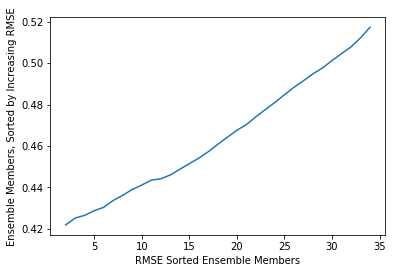

In [93]:
plt.plot(rs, score_st)
plt.xlabel("RMSE Sorted Ensemble Members")
plt.ylabel("Ensemble Members, Sorted by Increasing RMSE")
# plt.savefig("/home/nannau/.notable/attachments/rmse_kappa.png")
plt.show()

# plt.plot(rs, score_ens)

In [94]:
nn = rs[np.argmin(score_st)]
# nn=35
final = np.mean(np.array(finals)[np.argsort(stds)][:nn], axis=0)
finalnw = np.mean(np.array(final_noweighting), axis=0)
final.shape

(390, 465)

In [95]:
nn
np.array(finals)[np.argsort(stds)][:nn].shape

# np.array(final_noerr)[np.argsort(stds)][:nn].shape

(2, 390, 465)

In [96]:
# model_arr = np.array([find_nearest_index_value(
#     ds.rlon.values, 
#     ds.rlat.values, 
#     rlon_i_agg, 
#     rlat_i_agg, 
#     ds[dv].values[i, ...], final_mask, ds) for i in range(35)])

# ratio = ndf[station_dv].values/model_arr

# scores = np.arange(2, 20)

# # for k in range(2, 20):
# #     model = KNeighborsRegressor(n_neighbors=k, weights='distance')
# #     for f in np.linspace(-1, 10, 50):
# #         pwhole = pwhole_(f)
# #         for i in range(35):
# #             Y = ratio[i, :]
# #             X = np.stack([ndf.rlon, ndf.rlat]).T
# #             model.fit(X, Y)
            
# np.array(stations_pred_noerr).shape

In [97]:
# outside of polygon mask
c = []
for i in range(ndf.rlat.values.size):
    c.append(canada.contains(Point(ndf.rlon.values[i], ndf.rlat.values[i])).values[0])
c = np.array(c)
pred[c].shape, station_vals[c].shape, 

pred.size - np.sum(c)

39

In [101]:
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
ens_mean = np.mean(ds[dv].values, axis=0)
pred = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, final.copy(), final_mask, ds)
pred_perfect = np.mean(np.array(final_noerr), axis=0)
Snw = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, finalnw.copy(), final_mask, ds)

station_vals = ndf[station_dv].values

fmask_copy = final_mask.copy()
fmask_copy[rlat_i_agg, rlon_i_agg] = False

fmask_copy = np.logical_and(pwhole <= 1.0, fmask_copy)

plt.figure(figsize=(8, 8))
# plt.scatter(final[fmask_copy], np.mean(ds[dv].values[np.argsort(stds), ...][:nn, fmask_copy], axis=0), s=0.2, label='Mean at non-stations')
sns.scatterplot(finalnw[rlat_i_agg, rlon_i_agg], station_vals, hue=ndf['rlon'].values[c])
# plt.scatter(pred_perfect, np.mean(stations_pred_noerr, axis=0))
# sns.scatterplot(pred[c], station_vals[c], hue=ndf['distances'].values[c], marker='o', label='Stations')

plt.xlabel('Predictions')
plt.ylabel('Real')
# plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(final[fmask_copy], np.mean(ds[dv].values[np.argsort(stds), ...][:nn, fmask_copy], axis=0), s=0.2, label='Mean at non-stations')
plt.scatter(pred_perfect, np.mean(stations_pred_noerr, axis=0))
sns.scatterplot(pred, station_vals, hue=ndf['distances'].values, marker='o', label='Stations')

plt.xlabel('Predictions')
plt.ylabel('Real')
# plt.legend()
plt.show()



ValueError: arrays must all be same length

<Figure size 576x576 with 0 Axes>

Text(0, 0.5, 'Ratio between prediction and station value')

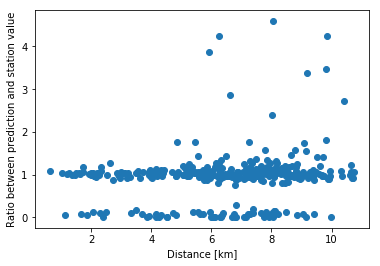

In [99]:
ratio_pre_station_vals = Snw/station_vals
plt.scatter(ndf['distances'].values, ratio_pre_station_vals)
plt.xlabel('Distance [km]')
plt.ylabel('Ratio between prediction and station value')

In [100]:
linregress(pred, station_vals), linregress(final[fmask_copy], ens_mean[fmask_copy])

(LinregressResult(slope=0.27553056747158355, intercept=0.22948246882635837, rvalue=0.6820396810444045, pvalue=3.91717707061586e-51, stderr=0.015527818256773972),
 LinregressResult(slope=0.7619645475739416, intercept=0.03557661328935113, rvalue=0.9308439187879726, pvalue=0.0, stderr=0.0011176641536659363))

In [222]:
ens_mean_with_nan = ens_mean.copy()
ens_mean_with_nan[~final_mask] = np.nan
ens_mean_with_nan = ens_mean_with_nan.reshape(ens_mean.shape)

In [262]:
import matplotlib
from matplotlib import cm
import numpy as np

magma_cmap = matplotlib.cm.get_cmap('RdBu', 125)
norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

magma_rgb = []

for i in range(0, 255):
    k = matplotlib.colors.colorConverter.to_rgb(magma_cmap(norm(i)))
    magma_rgb.append(k)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

magma = matplotlib_to_plotly(magma_cmap, 125)
new_magma = []
for i, color in enumerate(magma):
    if i < len(magma)-1:
        new_magma.append(color)
        new_magma.append(magma[i+1])

nmcopy = []        
for i in range(len(new_magma)):
    if i < len(new_magma)-1:
        nmcopy.append([new_magma[i][0], new_magma[i+1][1]])

nmcopy.append(magma[len(magma)-1])

In [264]:
fig = make_subplots(
    rows=2, cols=2, 
            subplot_titles=("Reconstruction",
                            'Reconstruction Residual (mean - reconstruction)',
                           'Ensemble Mean'),
            specs=[[{"type": "scatter"},
               {"type": "scatter"}],
                  [{"type": "scatter"},
               {"type": "scatter"}]])

fig.add_trace(
    go.Heatmap(
        z=final,
        x=ds.rlon.values,
        y=ds.rlat.values,
        zmin=0,
        zmax=1.2,
        hoverongaps = False,
        colorscale=nmcopy,
        showscale=True,
                    colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
#         colorbar=dict(title=dv, len=1.5, x=-0.2, y=.75),
        
    ),
    row=1, col=1
)

fig.add_scatter(
        x=ndf.rlon.values, 
        y=ndf.rlat.values,
        mode='markers',
        marker=dict(
            symbol='x',
            color=ndf[station_dv].values, 
            colorscale=nmcopy,
            colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
            line=dict(width=0.35, color='DarkSlateGrey'),
            showscale=False,
        ),
        text = ndf[station_dv].values,
        hoverinfo = 'text',
        hovertemplate =
            "<b>Station Value: %{text} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>",
    name=" Stations on Reconstruction",
    row=1,
    col=1   
)

fig.add_trace(
    go.Heatmap(
        z=ens_mean_with_nan-final,
        x=ds.rlon.values,
        y=ds.rlat.values,
        colorscale=nmcopy,
        zmin=-0.2,
        zmax=0.2,
        hoverongaps = False,
        showscale=True,
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
        
    ),
    row=1, col=2
)

fig.add_trace(
    go.Heatmap(
        z=ds[dv].values[0, ...],
        x=ds.rlon.values,
        y=ds.rlat.values,
        colorscale=nmcopy,
        zmin=0,
        zmax=1.,
        hoverongaps = False,
        showscale=False,
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
        
    ),
    row=2, col=1
)


fig.update_layout(
    title="<b>National Building Code K Nearest Neighbour Regression Results</b> Nic Annau, PCIC",
    font=dict(size=24),
    margin=dict(b=30),
    width=1800, 
    height=1030,
    showlegend=True,
    legend_orientation="v",
)


fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=1, col=1)
fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=1, col=2)
fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=2, col=1)



# fig.update_yaxes(title="Reconstruction", range=[(Y.flatten()**2).min()-0.2, (Y.flatten()**2).max()+0.2], row=1, col=2)
# fig.update_yaxes(title="Reconstruction", range=[(Y.flatten()**2).min()-0.2, (Y.flatten()**2).max()+0.2], row=2, col=2)

fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=1, col=1)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=1, col=2)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=2, col=1)

plotly.offline.plot(fig, filename='continuous.html')
# fig.write_image("/home/nannau/.notable/attachments/fig1.png")

'continuous.html'

In [107]:
rvalues = []
areas = np.linspace(1.0, 0.01, 300.)
for area in areas:
    fmask_copy = final_mask.copy()
#     fmask_copy[rlat_i_agg, rlon_i_agg] = False
    fmask_copy = np.logical_and(pwhole <= area, fmask_copy)
    rvalues.append(np.sqrt(mean_squared_error(final[fmask_copy], ens_mean[fmask_copy])))

plt.figure(figsize=(10,10))
plt.plot(areas, rvalues, label='Mean and Reconstruction RMSE')
plt.hlines(np.sqrt(mean_squared_error(pred, station_vals)), areas.min(), areas.max(), linestyles='dashed', label='Stations and Reconstruction RMSE')
plt.hlines(np.sqrt(mean_squared_error(final[final_mask], ens_mean[final_mask])), areas.min(), areas.max(),  linestyles='dashdot', color='red', label='Mean and Reconstruction Overall')
plt.gca().invert_xaxis()
plt.legend()
plt.title("RMSE Between Ensemble Mean and Reconstruction as a Funcion of Station Density")
plt.xlabel("Softmax Value (Increasing Distance from Station to right)")
plt.ylabel("RMSE")
plt.savefig('/home/nannau/.notable/attachments/rmse_reconstruction_profile')

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [629]:
np.sqrt(mean_squared_error(final[final_mask], ens_mean[final_mask]))

0.03122772320764899

In [630]:
np.sqrt(mean_squared_error(pred, station_vals)), np.sqrt(mean_squared_error(final[final_mask], ens_mean[final_mask]))

(0.045533120564045064, 0.03122772320764899)

In [631]:
np.sqrt(mean_squared_error(pred, station_vals))

0.045533120564045064

In [632]:
print(
    np.sqrt(mean_squared_error(pred, station_vals))/np.amax(station_vals)*100,
    np.sqrt(mean_squared_error(final[final_mask], ens_mean[final_mask]))/np.amax(ens_mean[final_mask])*100
)

4.022360473855571 3.1744616237358922
